In [1]:
import sys, os 
import numpy as np 
import pandas as pd
from src import utils, plots
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import sem
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import rcParams
default_font = 12
fs_title = 16
rcParams["font.family"] = "Arial"
rcParams["savefig.dpi"] = 300
rcParams["axes.spines.top"] = False
rcParams["axes.spines.right"] = False
rcParams["axes.titlelocation"] = "left"
rcParams["axes.titleweight"] = "normal"
rcParams["font.size"] = default_font
trial_type_palette = ['tab:green', 'tab:red', 'tab:cyan', 'tab:orange', 'grey'] #rew #nrew #rew_test #nrew_test #GI

In [2]:
VG11 = []
VG11.append({'mname': 'VG11', 'datexp': '2024_10_31', 'blk':'2'})
VG11.append({'mname': 'VG11', 'datexp': '2024_11_14', 'blk':'2'})
VG14 = []
VG14.append({'mname': 'VG14', 'datexp': '2024_11_21', 'blk':'2'})
VG15 = []
VG15.append({'mname': 'VG15', 'datexp': '2024_10_31', 'blk':'2'})
behav_sess = VG11 + VG14 + VG15

In [3]:
def get_dummy_vars(m1, lick_window=(150,250)):
    ntrials = m1.interp_spks.shape[1]
    rewarded = np.zeros(ntrials, dtype=bool)
    correct = np.zeros(ntrials, dtype=bool)
    rew_trials = np.concatenate((m1.trial_dict["rewarded"], m1.trial_dict["rewarded test"]))
    rewarded[rew_trials] = 1
    for i_t, (ttype, trials) in enumerate(m1.trial_dict.items()):
        if ttype in ["rewarded", "rewarded test"]:
            t_licks, _ = utils.get_trials_with_licks(m1, lick_window=lick_window, trialtype=ttype)
            correct[t_licks] = 1
        if ttype in ["non rewarded", "non rewarded test"]:
            _, t_no_licks = utils.get_trials_with_licks(m1, lick_window=lick_window, trialtype=ttype)
            correct[t_no_licks] = 1
    return rewarded, correct

def dprime_cell(m1, condition1, condition2, discrimination_region=(0,125), subpop=None):
    """
    Compute the d-prime for a single cell.
    """
    response = m1.interp_spks[:,:,discrimination_region[0]:discrimination_region[1]].mean(2)
    r1 = response[:, condition1]
    r2 = response[:, condition2]
    if subpop is not None:
        r1 = r1[subpop]
        r2 = r2[subpop]
    # collect means and stds
    mu1 = r1.mean(1)
    mu2 = r2.mean(1)
    std1 = r1.std(1) + np.finfo(np.float64).tiny
    std2 = r2.std(1) + np.finfo(np.float64).tiny
    #compute the train dprime
    dp = 2 * ((mu1 - mu2) / (std1 + std2))
    return dp

In [4]:
from pathlib import Path
areas = ["V1", "medial", "lateral", "anterior"]
name = VG11[0]['mname']
date = VG11[0]['datexp']
blk = VG11[0]['blk']
m1 = utils.load_mouse(name, date, blk, load_neurons=True, interp_behav=True, load_retinotopy=True, mdl_path=r"D:\mouseobj\notz")
ntrials = m1.interp_spks.shape[1]
ncells = m1.interp_spks.shape[0]
utils.compute_dprime(m1, discrimination_region=(0,125), concatenate=False, remove_mean=False)

Checking if model object exists ...
Loading mouse object from D:\mouseobj\notz\VG11\2024_10_31\2
Existing mouse object has the following attributes:
dict_keys(['name', 'datexp', 'blk', 'data_path', '_timeline', '_data_var', '_settings', '_timestamps', '_trial_info', '_spks', '_ypos', '_xpos', '_iplane', '_stat', '_ops', '_snr', 'xy_t', 'iarea', 'iregion', 'outline', 'frameselector', 'isred', 'interp_spks', 'trial_dict', 'train_dp'])
dprime saved in MouseObject.train_dp (neurons) using even trials


for sake of the modeling lets only use medial/excitatory neurons

In [5]:
ia = utils.get_region_idx(m1.iarea, "medial")
selected_type = np.logical_not(m1.isred[:,0]).astype(bool)
pstv_tsh, ngtv_tsh = utils.get_dp_thresholds(m1.train_dp[ia*selected_type], tsh=95) 
prefer_r = (m1.train_dp>=pstv_tsh)
prefer_nr = (m1.train_dp<=ngtv_tsh)
selective_neurons = prefer_r + prefer_nr
subpop = ia * selective_neurons * selected_type
dp_ontest = dprime_cell(m1, m1.trial_dict["rewarded test"], m1.trial_dict["non rewarded test"], discrimination_region=(0,125), subpop=subpop)
sp = m1.interp_spks[subpop]
rewarded, correct = get_dummy_vars(m1, lick_window=(150,250))
cr = rewarded * correct
iom = rewarded * np.logical_not(correct)
co = np.logical_not(rewarded) * correct
fa = np.logical_not(rewarded) * np.logical_not(correct)

We model each neuron avg response on (0,125) as a linear combitnation of:

C: Category
B: Behavior Output
CB : Interaction

$Y = \alpha + \beta{_0}C + \beta{_1}B + \beta{_2}CB$


In [6]:
import statsmodels.api as sm

def fit_two_factor_model(neuron_resp, category_labels, behavior_labels):
    """
    Fits linear model: resp ~ category + behavior + interaction
    neuron_resp: shape (n_trials,)
    """
    df = pd.DataFrame({
        'resp': neuron_resp,
        'C': category_labels,
        'B': behavior_labels
    })
    df['CB'] = df['C'] * df['B']
    X = df[['C', 'B', 'CB']].astype(float)
    X = sm.add_constant(X)
    y = df['resp'].astype(float)
    
    model = sm.OLS(y, X).fit()
    return model

In [7]:
sp = sp[:,:, 0:125].mean(2)
results = []
for i in range(sp.shape[0]):
    neuron_resp = sp[i, :]
    model = fit_two_factor_model(neuron_resp, rewarded, correct)
    results.append({
        'alpha': model.params['const'],
        'beta_C': model.params['C'],
        'beta_B': model.params['B'],
        'beta_CB': model.params['CB'],
        'p_C': model.pvalues['C'],
        'p_B': model.pvalues['B'],
        'p_CB': model.pvalues['CB'],
        'r2': model.rsquared,
        'dprime': dp_ontest[i]
    })

df_results = pd.DataFrame(results)
alpha = 0.05
df_results['significant_C'] = df_results['p_C'] < alpha
df_results['significant_B'] = df_results['p_B'] < alpha
df_results['significant_CB'] = df_results['p_CB'] < alpha

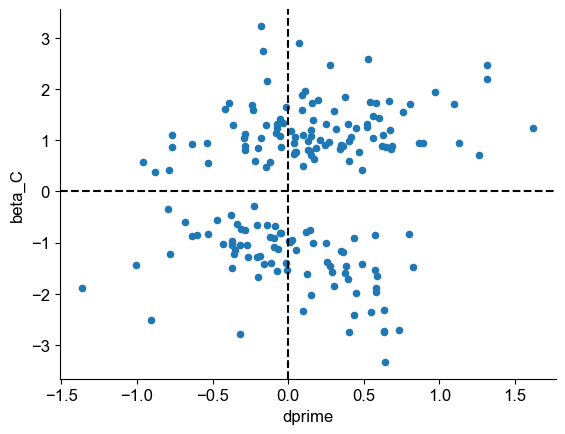

In [8]:
df_results.query('significant_C == True').plot(x='dprime', y='beta_C', kind='scatter')
plt.axhline(0, color='k', linestyle='--')
plt.axvline(0, color='k', linestyle='--')

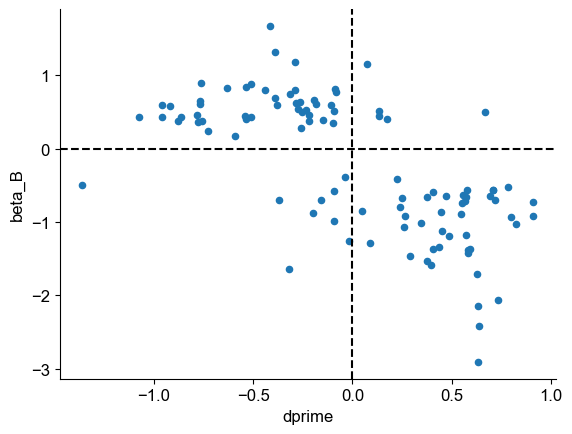

In [9]:
df_results.query('significant_B == True').plot(x='dprime', y='beta_B', kind='scatter')
plt.axhline(0, color='k', linestyle='--')
plt.axvline(0, color='k', linestyle='--')

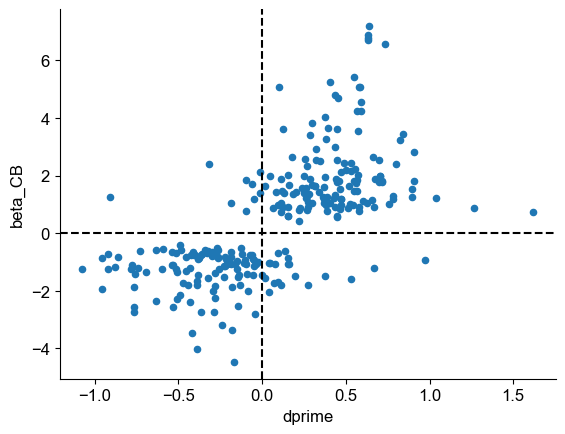

In [10]:
df_results.query('significant_CB == True').plot(x='dprime', y='beta_CB', kind='scatter')
plt.axhline(0, color='k', linestyle='--')
plt.axvline(0, color='k', linestyle='--')

But this model is not satisfactory, because we are not capturing directly the gain of the activity (it doesn't depend on activity)

Reformulation:

$r_{ik} = (1+g_{k}a_{i})\mu_{ij}$

i = neuron, k = trial, j = trial_type

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
ia = utils.get_region_idx(m1.iarea, "medial")
selected_type = np.logical_not(m1.isred[:,0]).astype(bool)
pstv_tsh, ngtv_tsh = utils.get_dp_thresholds(m1.train_dp[ia*selected_type], tsh=95) 
prefer_r = (m1.train_dp>=pstv_tsh)
prefer_nr = (m1.train_dp<=ngtv_tsh)
selective_neurons = prefer_r + prefer_nr
subpop = ia * selective_neurons * selected_type
dp_ontest = dprime_cell(m1, m1.trial_dict["rewarded test"], m1.trial_dict["non rewarded test"], discrimination_region=(0,125), subpop=subpop)
sp_sub = utils.interp_spks_by_corridorlength(m1, m1.frameselector, z=False, corridor_length=400, subsample_factor=20) #subsample corridor interpolation to only have 20 samples

39 13396
interpolating 29842 neurons, 13358 frames to
the vector of distance with shape: (13358,)
neurons: 29842, trials: 254, corridor length: 20


In [13]:
sp = sp_sub[subpop]
n_neurons, n_trials, n_positions = sp.shape
r_ik = sp.reshape(-1)
reward, correct = get_dummy_vars(m1, lick_window=(150,250))
cr = reward * correct
iom = reward * np.logical_not(correct)
co = np.logical_not(reward) * correct
fa = np.logical_not(reward) * np.logical_not(correct)

# get a vector with a 0, 1, 2, 3 for each trial type 
trial_type = np.zeros(n_trials, dtype=int)
for it, ttype in enumerate([cr, iom, co, fa]):
    trial_type[ttype] = it

neuron_idx = np.repeat(np.arange(n_neurons), n_trials * n_positions)
trial_idx = np.tile(np.repeat(np.arange(n_trials), n_positions), n_neurons)
ttype_idx = trial_type[trial_idx]
category_idx = reward[trial_idx]
# Here i get the trial avg per category / neuron
avg_per_ttype = np.zeros((n_neurons, n_trials, 20))
for it, ttype in enumerate([rewarded, np.logical_not(rewarded)]):
    t_response = sp[:,ttype,:]
    avg_per_ttype[:,ttype,:] = t_response.mean(1, keepdims=True)
mu_ij = avg_per_ttype.reshape(-1)

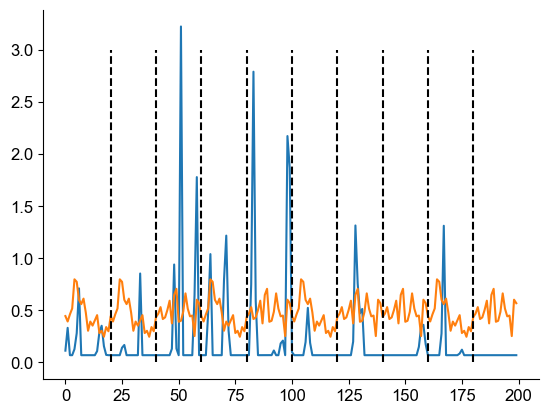

In [14]:
# predicting the response
plt.plot(r_ik[:200]) #observed
plt.plot(mu_ij[:200]) #initiation values
plt.vlines(np.arange(20, 200, 20), ymin=0, ymax=3, color='k', linestyle='--')

In [15]:
r_ik = torch.tensor(r_ik, dtype=torch.float32, device=device)
neuron_idx = torch.tensor(neuron_idx, dtype=torch.long, device=device)
category_idx = torch.tensor(category_idx, dtype=torch.long, device=device)
ttype_idx = torch.tensor(ttype_idx, dtype=torch.long, device=device)
trial_idx = torch.tensor(trial_idx, dtype=torch.long, device=device)
n_neurons = neuron_idx.max().item() + 1
n_categories = category_idx.max().item() + 1
n_trials = trial_idx.max().item() + 1
g = torch.nn.Parameter(torch.ones(n_trials, device=device))
a = torch.nn.Parameter(torch.ones(n_neurons, device=device))
mu = torch.nn.Parameter(torch.tensor(mu_ij, device=device))
optimizer = torch.optim.AdamW([g, a, mu], lr=1e-3, weight_decay=1e-3)

for epoch in range(2500):
    optimizer.zero_grad()
    #interaction = torch.einsum('i,j->ij', a, g)
    #scaling = (1 + interaction)
    #pred = scaling * mu
    pred = (1 + g[trial_idx] * a[neuron_idx]) * mu
    loss = ((pred - r_ik) ** 2).mean()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 9.7058
Epoch 100, Loss: 7.5834
Epoch 200, Loss: 6.2964
Epoch 300, Loss: 5.4624
Epoch 400, Loss: 4.8821
Epoch 500, Loss: 4.4503
Epoch 600, Loss: 4.1087
Epoch 700, Loss: 3.8239
Epoch 800, Loss: 3.5759
Epoch 900, Loss: 3.3524
Epoch 1000, Loss: 3.1456
Epoch 1100, Loss: 2.9506
Epoch 1200, Loss: 2.7642
Epoch 1300, Loss: 2.5846
Epoch 1400, Loss: 2.4108
Epoch 1500, Loss: 2.2426
Epoch 1600, Loss: 2.0802
Epoch 1700, Loss: 1.9241
Epoch 1800, Loss: 1.7750
Epoch 1900, Loss: 1.6335
Epoch 2000, Loss: 1.5001
Epoch 2100, Loss: 1.3752
Epoch 2200, Loss: 1.2591
Epoch 2300, Loss: 1.1515
Epoch 2400, Loss: 1.0523


Model R²: 0.856


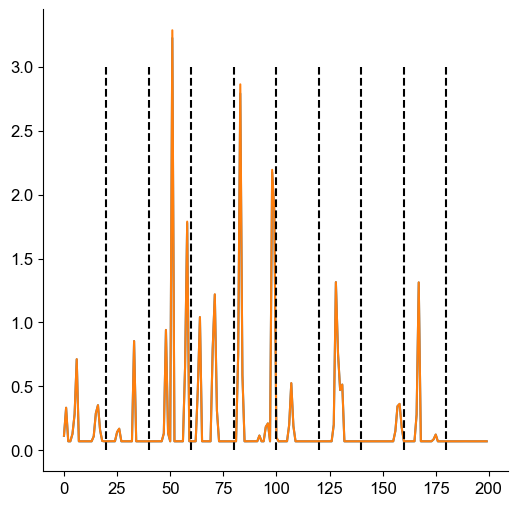

In [16]:
plt.figure(figsize=(6, 6))
from sklearn.metrics import r2_score
r2 = r2_score(r_ik.cpu().detach().numpy(), pred.cpu().detach().numpy())
print(f"Model R²: {r2:.3f}")
plt.plot(r_ik.cpu().detach().numpy()[:200])
plt.plot(pred.cpu().detach().numpy()[:200])
plt.vlines(np.arange(20, 200, 20), ymin=0, ymax=3, color='k', linestyle='--')

In [17]:
g_vals = g.detach().cpu().numpy()
a_vals = a.detach().cpu().numpy()

Text(0, 0.5, 'Density')

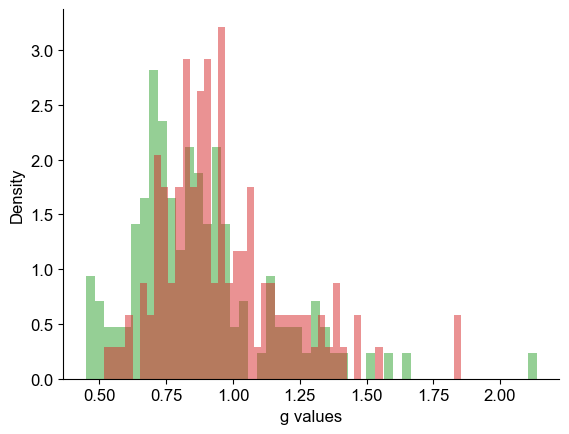

In [18]:
plt.hist(g_vals[reward==1], bins=50, alpha=0.5, label='rewarded', color='tab:green', density=True);
plt.hist(g_vals[reward==0], bins=50, alpha=0.5, label='non rewarded', color='tab:red', density=True);
plt.xlabel('g values')
plt.ylabel('Density')

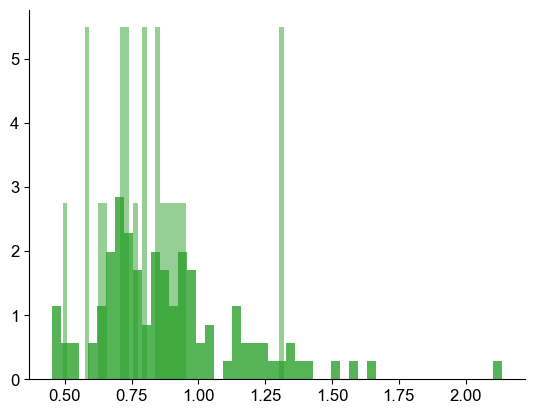

In [19]:
plt.hist(g_vals[cr], bins=50, alpha=0.8, color='tab:green', density=True);
plt.hist(g_vals[iom], bins=50, alpha=0.5, color='tab:green', density=True);

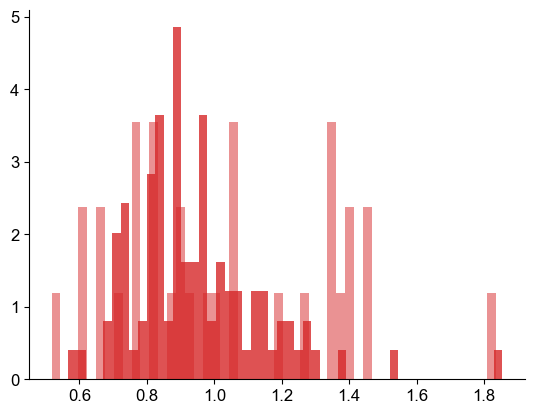

In [20]:
plt.hist(g_vals[co], bins=50, alpha=0.8, color='tab:red', density=True);
plt.hist(g_vals[fa], bins=50, alpha=0.5, color='tab:red', density=True);

Text(0, 0.5, 'gain')

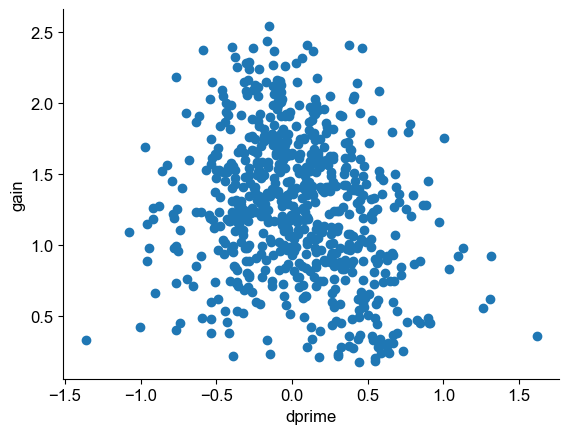

In [21]:
plt.scatter(dp_ontest, a_vals)
plt.xlabel("dprime")
plt.ylabel("gain")

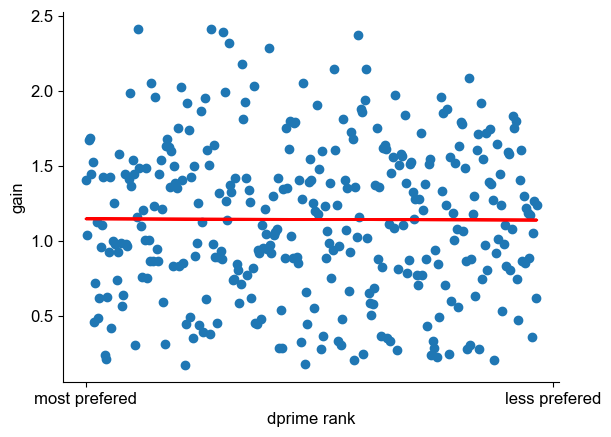

In [37]:
plt.scatter(np.argsort(dp_ontest[dp_ontest>0])[::-1], a_vals[dp_ontest>0])
# add regression line
from sklearn.linear_model import LinearRegression
X = np.argsort(dp_ontest[dp_ontest>0])[::-1].reshape(-1, 1)
y = a_vals[dp_ontest>0]
model = LinearRegression()
model.fit(X, y)
plt.plot(X, model.predict(X), color='red', linewidth=2)
plt.ylabel("gain")
plt.xlabel("dprime rank")
plt.xticks([0, 350], ["most prefered", "less prefered"]);

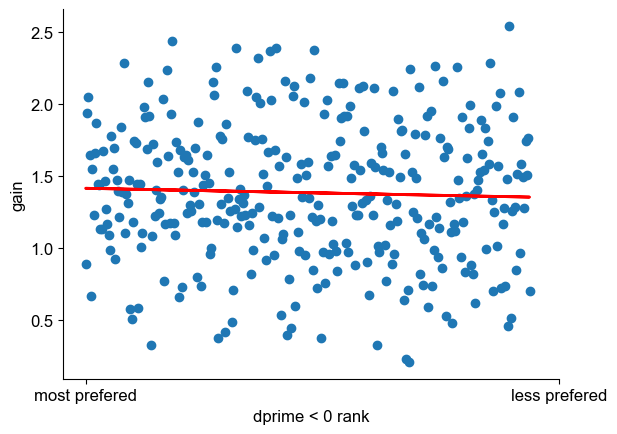

In [38]:
plt.scatter(np.argsort(dp_ontest[dp_ontest<0]), a_vals[dp_ontest<0])
from sklearn.linear_model import LinearRegression
X = np.argsort(dp_ontest[dp_ontest<0]).reshape(-1, 1)
y = a_vals[dp_ontest<0]
model = LinearRegression()
model.fit(X, y)
plt.plot(X, model.predict(X), color='red', linewidth=2)
plt.ylabel("gain")
plt.xlabel("dprime < 0 rank")
plt.xticks([0, 350], ["most prefered", "less prefered"]);

What's the best way to incorporate the incercept?

$r_{ik} = \alpha_{i}h_{k} + (1+g_{k}a_{i})\mu_{ij}$

* Can we fit all neurons at once? 
* should we incorporate a parameter that captures the area gain? or thats already captured if we fit all neurons at once? 

* If one hypothesis is that correct and incorrect trials for each category have different gains (additive or multiplicative), it is enough to show that with the distribution of parameters?

* another hypothesis is that the gains might be related to how much neurons are modulated by the category (dprime), how is the best way to capture that?
    * only on the prototype most selective neurons? or on every neuron, computing dprime in a different way??

Is this a good way to capture the gain of the activity? 

At the end this will impose more gain on neurons than deviate from the mean, that mean is also biased by the prototype trial